In [1]:
!pip install opencv-python -q
!pip install tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sahebgoudkaraddi/respiratorypulmonarylung-diseases-radiographs")

print("Path to dataset files:", path)

100%|██████████| 1.02G/1.02G [00:05<00:00, 198MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sahebgoudkaraddi/respiratorypulmonarylung-diseases-radiographs/versions/1


# FUNCIONES VARIAS

In [4]:
def crear_path(ruta,enfermedades):
  fotos = []
  for enfermedad in enfermedades:
    ruta_enf = f'{ruta}/{enfermedad}'
    for foto in os.listdir(ruta_enf):
      ruta_foto = f'{ruta_enf}/{foto}'
      fotos.append(foto)

def crear_path2(ruta,enfermedades):
  return [f'{ruta}/{enfermedad}/{foto}' for enfermedad in enfermedades for foto in os.listdir(f'{ruta}/{enfermedad}')]


In [5]:
def cargar_imagenes(rutas):
  fotos = [cv2.imread(ruta, cv2.IMREAD_GRAYSCALE) for ruta in rutas]
  etiquetas = [ruta.split('/')[-1].split('-')[0] if ruta.split('/')[-1].split('-')[0] == 'COVID'
               else ruta.split('/')[-1].split('(')[0] if ruta.split('/')[-1].split('(')[0] == 'TUBERCULOSIS'
               else ruta.split('/')[-1].split('-')[0].upper() if ruta.split('/')[-1].split('-')[0] == 'Tuberculosis'
               else ruta.split('/')[-1].split('(')[0].split('_')[0] if ruta.split('/')[-1].split('(')[0] == 'HEALTHY_NORMAL'
               else ruta.split('/')[-1].split(' ')[0]  for ruta in rutas ]
  return fotos,etiquetas


In [6]:

def redimensionar(imagen, dimensiones):
    # dimensiones = (ancho, alto)
    ratio = min(dimensiones[0] / imagen.shape[1], dimensiones[1] / imagen.shape[0])
    nuevo_ancho = int(imagen.shape[1] * ratio)
    nuevo_alto = int(imagen.shape[0] * ratio)
    img_redimensionada = cv2.resize(imagen, (nuevo_ancho, nuevo_alto))
    mascara = np.zeros((dimensiones[1], dimensiones[0]), np.uint8)  # (alto, ancho)
    y_offset = (dimensiones[1] - nuevo_alto) // 2
    x_offset = (dimensiones[0] - nuevo_ancho) // 2
    mascara[y_offset:y_offset + nuevo_alto, x_offset:x_offset + nuevo_ancho] = img_redimensionada
    return mascara

In [7]:
def codificar_etiquetas(etiquetas):
  encoder = LabelEncoder()
  etiquetas_cod = encoder.fit_transform(etiquetas)
  return to_categorical(etiquetas_cod),encoder

# ENRUTADO Y CARGA DE IMAGENES


In [8]:
ruta = f'{path}/{os.listdir(path)[0]}'
enfermedades = os.listdir(ruta)
enfermedades = [enfermedad for enfermedad in enfermedades if enfermedad != 'LC']
rutas_imagenes = crear_path2(ruta,enfermedades)

In [9]:
imagenes,etiquetas = cargar_imagenes(rutas_imagenes)

# PROCESAMIENTO DE DATOS

Los procesos que se hacen son:
- cargar las imagenes
- se ponen en escala de grises
- Redimensiona

In [10]:
imagenes_red = np.array([redimensionar(imagen,(512,512))/255.0 for imagen in imagenes])

In [11]:
etiquetas_onehot,encoder = codificar_etiquetas(etiquetas)

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(
    imagenes_red,
    etiquetas_onehot,
    test_size = 0.3,
    stratify = etiquetas,
    random_state = 11
)

etiquetas_val = encoder.inverse_transform(np.argmax(y_temp, axis=1))

x_test, x_val, y_test, y_val = train_test_split(
    x_temp,y_temp,
    test_size=0.5,
    stratify= etiquetas_val,
    random_state = 11
)


# MODELO

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation


In [14]:
modelo = Sequential()

modelo.add(Conv2D(32, (3,3), input_shape=(512,512,1), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

modelo.add(Conv2D(64, (3,3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

modelo.add(Conv2D(128, (3,3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))


modelo.add(Flatten())

modelo.add(Dense(128, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(7,activation='softmax'))

modelo.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073,799 (240.61 MB)

 Trainable params: 63,073,799 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
modelo.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
historial = modelo.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=3,
    batch_size=32
)


Epoch 1/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 2291s 15s/step - accuracy: 0.5145 - loss: 1.8883 - val_accuracy: 0.8081 - val_loss: 0.6403
Epoch 2/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 2287s 15s/step - accuracy: 0.7981 - loss: 0.6515 - val_accuracy: 0.8396 - val_loss: 0.4707
Epoch 3/3
149/149 ━━━━━━━━━━━━━━━━━━━━ 2281s 15s/step - accuracy: 0.8547 - loss: 0.4533 - val_accuracy: 0.8573 - val_loss: 0.4388


# EVALUACION

32/32 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step
Accuracy: 0.86
Precision: 0.89
Recall:    0.71
F1-score:  0.74


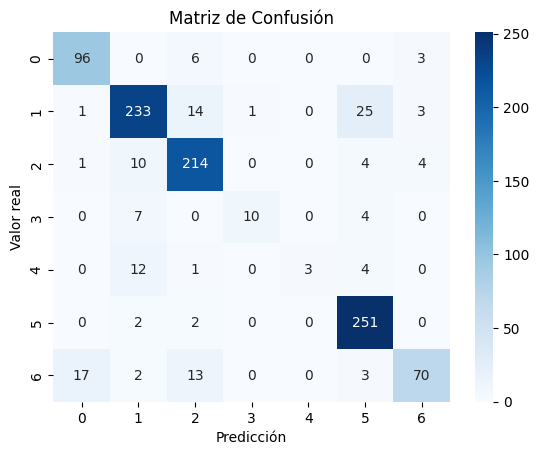

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

predicciones = modelo.predict(x_test)
y_pred = np.argmax(predicciones, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()


In [18]:
import pickle
modelo.save('modelo_enfermedades_pulmonares.h5')
modelo.save('modelo_enfermedades_pulmonares.keras')
with open('historial_modelo_pulmonar.pkl', 'wb') as file:
    pickle.dump(historial, file)

In [19]:
import joblib

joblib.dump(encoder, 'label_encoder_enfermedades_pulmonares.pkl')

['label_encoder_enfermedades_pulmonares.pkl']